# Blackjack

this notebook examines a couple different results in the context of the card game blackjack. The card deck file can be found [here](https://github.com/michaelneuder/numerical_experiments/blob/master/cards/card_deck.py).

In [1]:
from card_deck import deck
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 10
plt.rcParams["font.size"] = "20"

The first thing I want to explore is extremely simple. I want to use repititive random sampling to estimate the probability of being dealt a score of 21 in the poker game Black Jack in the starting hand of two cards. This can quite simply be calculated deterministically as:
$$\frac{16}{52} \cdot \frac{4}{51} + \frac{4}{52} \cdot \frac{16}{51} = \frac{128}{2652} \approx .0483.$$
Lets see how close we can get to that with repeated random sampling.

In [3]:
def score_starting_hand_blackjack(hand):
    vals = hand[0][0], hand[1][0]
    score = 0
    for val in vals:
        if val > 10:
            score += 10
        elif val == 1:
            score += 11
        else:
            score += val
    return score

In [5]:
def simulate_blackjack_2cards(trials):
    hand_frequency = np.zeros((13,13))
    cards = deck(start_shuffled = False)
    num_trials = trials
    num_blackjacks = 0
    for i in range(num_trials):
        cards.shuffle()
        hand = cards.deal(2)
        hand_frequency[hand[0][0]-1, hand[1][0]-1] += 1
        score = score_starting_hand_blackjack(hand)
        if score == 21:
            num_blackjacks += 1
    return num_blackjacks / num_trials, hand_frequency

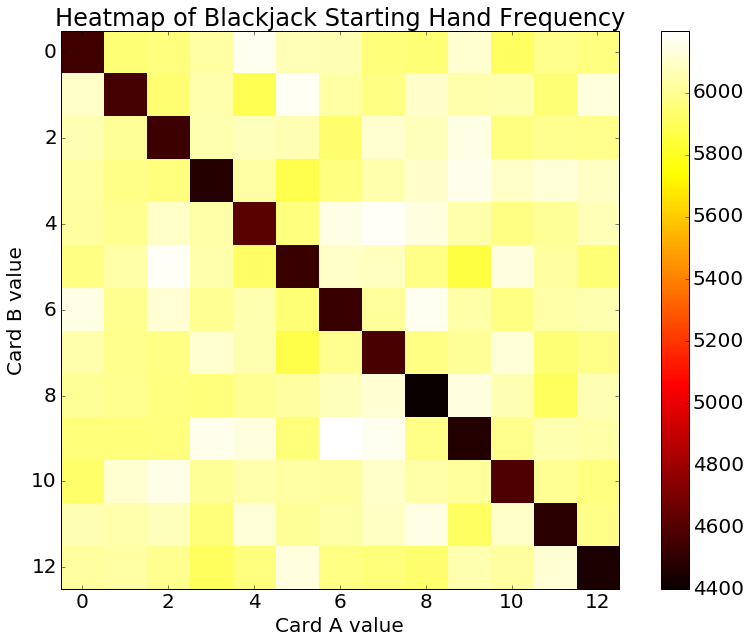

In [6]:
trials = 1000000
prob, freqs = simulate_blackjack_2cards(trials)
plt.imshow(freqs, cmap='hot', interpolation='nearest')
plt.xlabel('Card A value')
plt.ylabel('Card B value')
plt.title('Heatmap of Blackjack Starting Hand Frequency')
plt.colorbar()
plt.show()

In [7]:
print('estimated probability of blackjack from initial deal:', prob)

estimated probability of blackjack from initial deal: 0.047955


Not too much interesting in the heatmap except the fact that the probability of getting a pair of same cards is significantly lower than the rest of the probabilities. Our estimated probability of getting a blackjack is quite stellar as well at $P(\text{BlackJack on first two cards}) \approx .048$. Now we can investigate a more difficult problem... what is the probability of getting a 21 in the entire hand. In this question we have to explore potentially many more than just the two initial cards. Just in the case of three cards, there are many more ways to get 21 than just a value ten and an ace (i.e. $ [7,7,7], [7,8,6], [7,9,5], ...$). Clearly with three cards it becomes much more complicated, but still deterministically reasonable. Once you continue on though, it gets rather ridiculous, especially considering hands like $[1,1,1,1,2,2,2,2,3,3,3] = 21$. Solving this entire probability would be quite the adventure, though I don't doubt a good probabilist with a lot of time could do it. I want to use a monte carlo method to estimate this value. The process is simple... check the score of the current hand, and if it is less than 21, get dealt another card (of course this wouldn't be a very wise playing strategy). Let's see what happens.  

In [8]:
def simulate_blackjack_hit_to_21(trials):
    cards = deck(start_shuffled = False)
    num_cards_21 = {}
    num_trials = trials
    num_blackjacks = 0
    for i in range(num_trials):
        cards.shuffle()
        hand = cards.deal(2)
        num_cards = 2
        score = score_starting_hand_blackjack(hand)
        while score < 21:
            num_cards += 1
            hit = cards.deal(1)
            score += hit[0][0]
        if score == 21:
            num_blackjacks += 1
            try:
                num_cards_21[num_cards] += 1
            except KeyError:
                num_cards_21[num_cards] = 1
    for card_num in num_cards_21:
        num_cards_21[card_num] /= trials
    return num_blackjacks / num_trials, num_cards_21

In [9]:
trials = 100000
prob, distribution = simulate_blackjack_hit_to_21(trials)
print('probability of getting a 21 during game = {:.4f}'.format(prob))

probability of getting a 21 during game = 0.1592


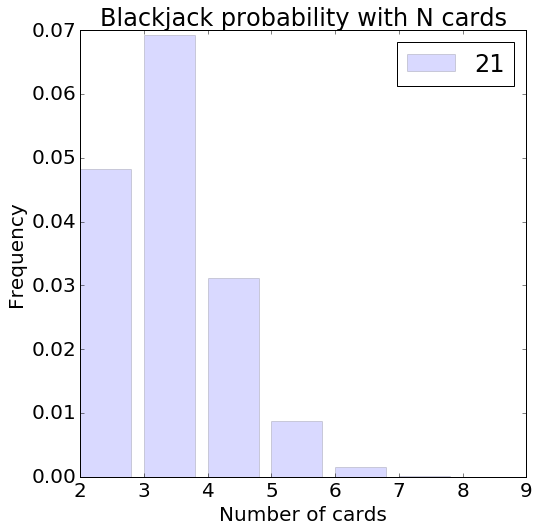

In [10]:
plt.rcParams["figure.figsize"] = (8,8)
plt.bar(distribution.keys(), distribution.values(), color='b', alpha=.15, label='21')
plt.xlabel('Number of cards')
plt.ylabel('Frequency')
plt.legend()
plt.title('Blackjack probability with N cards')
plt.show()

I think this is pretty neat. Clearly a skewed normal distribution, but its hard to get much data because 21's with more than 8 cards are so rare. But as we said earlier, just hitting till you get 21 isn't a very intelligent strategy. You will get a 21 about 16% of the time, but the other 84% will be busts. So next I want to investigate the probability of getting a good hand. I am using a hand of 18+ as a good hand. So the probability of getting a good hand can be seen as $$ P(\text{good}) = P(18) + P(19) + P(20) + P(21).$$ Thus I can modify the previous experiment to set a threshold below 21 to be the point where we stop taking more cards. Check it out.

In [41]:
def simulate_blackjack_hit_to_n(trials, n):
    cards = deck(start_shuffled = False)
    num_cards_end = {}
    max_cards = 2
    num_trials = trials
    num_blackjacks = 0
    for i in range(num_trials):
        cards.shuffle()
        hand = cards.deal(2)
        num_cards = 2
        score = score_starting_hand_blackjack(hand)
        while score < n:
            num_cards += 1
            hit = cards.deal(1)
            score += hit[0][0]
        if score == n:
            if num_cards > max_cards:
                max_cards = num_cards
            num_blackjacks += 1
            try:
                num_cards_end[num_cards] += 1
            except KeyError:
                num_cards_end[num_cards] = 1
    for card_num in num_cards_end:
        num_cards_end[card_num] /= trials
    return num_blackjacks / num_trials, num_cards_end, max_cards

In [57]:
good_scores = np.arange(18,22)
frequencies = {}
trials = 100000
max_cards = 0
for score in good_scores:
    prob, distribution, max_cards_temp = simulate_blackjack_hit_to_n(trials, score)
    if max_cards_temp > max_cards:
        max_cards = max_cards_temp
    frequencies[score] = distribution
    print('probability of getting a {} during game = {:.4f}'.format(score,prob))

probability of getting a 18 during game = 0.1424
probability of getting a 19 during game = 0.1472
probability of getting a 20 during game = 0.2001
probability of getting a 21 during game = 0.1575


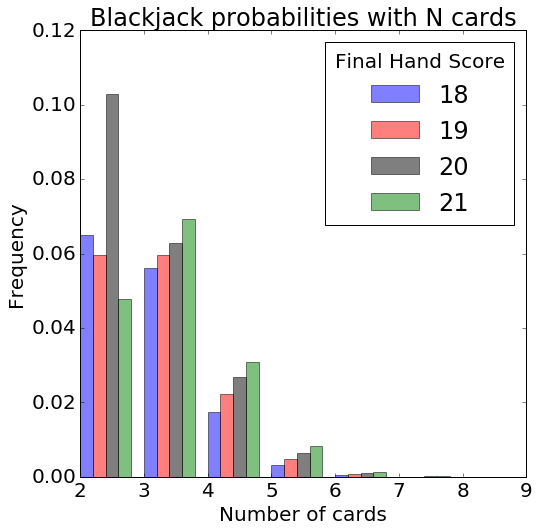

In [77]:
plt.rcParams["figure.figsize"] = (8,8)
count = 0
color_list = ['b','r','k','g']
for distribution in frequencies:
    plt.bar(np.asarray(list(frequencies[distribution].keys()))+count*.2, list(frequencies[distribution].values()), 
            alpha=.5, width=.2 ,label=distribution, color=color_list[count])
    count += 1
plt.xlabel('Number of cards')
plt.ylabel('Frequency')
plt.legend(title='Final Hand Score')
plt.title('Blackjack probabilities with N cards')
plt.show()

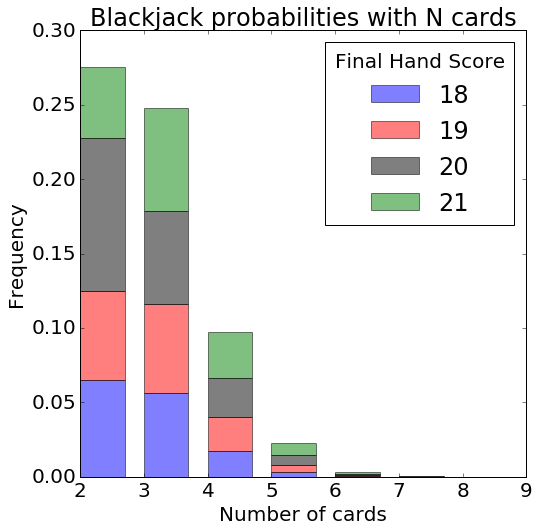

In [78]:
bottoms = {}
for freq in frequencies:
    bottoms[freq] = []
    for i in range(2,max_cards+1):
        try:
            frequencies[freq][i]
        except KeyError:
            frequencies[freq][i] = 0
    
for i in range(2,max_cards+1):
    bottoms[18].append(0)
    bottoms[19].append(frequencies[18][i])
    bottoms[20].append(frequencies[18][i] + frequencies[19][i])
    bottoms[21].append(frequencies[18][i] + frequencies[19][i] + frequencies[20][i])

count = 0
for distribution in frequencies:
    plt.bar(np.asarray(list(frequencies[distribution].keys())), list(frequencies[distribution].values()), 
            alpha=.5, width=.7 ,label=distribution, color=color_list[count], bottom=bottoms[distribution])
    count += 1
plt.xlabel('Number of cards')
plt.ylabel('Frequency')
plt.legend(title='Final Hand Score')
plt.title('Blackjack probabilities with N cards')
plt.show()